## Set-up

Note that this notebook requires both the `onnx` and `onnxruntime` optional dependencies, in addition to `opencv-python` and `matplotlib` for visualization.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import  SamPredictor,build_sam_vit_h
import os 
import json
import onnxruntime
import torch
from helpers import Item, to_file,mock_sam

def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  


In [2]:
items=[]
checkpoint = "../sam_vit_h_4b8939.pth"
sam = build_sam_vit_h()
mock_sam(sam)

torch.Size([4, 1, 2, 2])
1280 256


## Example Image

In [3]:
image = cv2.imread('../images/dog.jpg')

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
items.append(Item("image",image,"TensorUint8"))

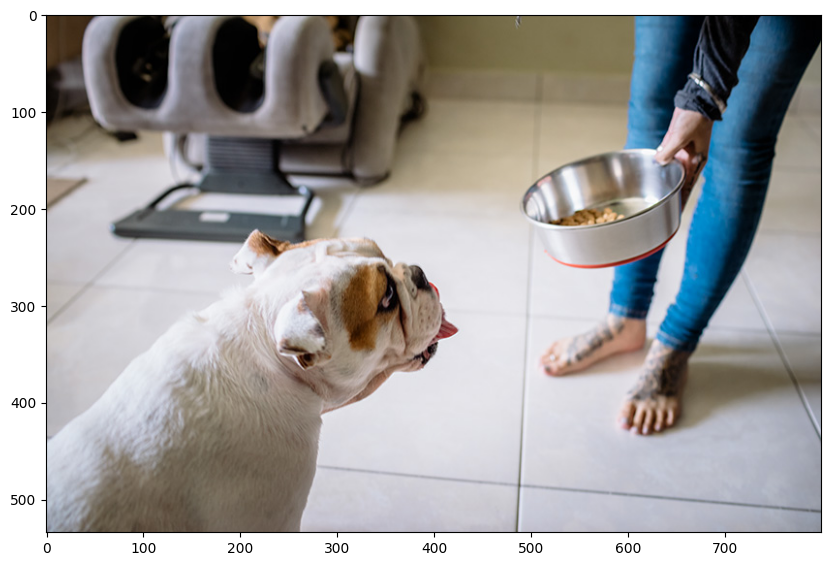

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Using an ONNX model

In [5]:
ort_session = onnxruntime.InferenceSession("../sam.onnx")

In [6]:
sam.to(device='cpu')
predictor = SamPredictor(sam)

In [7]:
predictor.set_image(image)

In [8]:
image_embedding = predictor.get_image_embedding().cpu().numpy()
items.append(Item("image_embedding",image_embedding,"TensorFloat"))


### Example point input

In [9]:
input_point = np.array([[100, 375]]).astype(np.float32)
input_label = np.array([1]).astype(np.float32)
items.append(Item("input_point",input_point,"TensorFloat"))
items.append(Item("input_label",input_label,"TensorFloat"))

Add a batch index, concatenate a padding point, and transform.

In [10]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :].astype(np.float32)
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)
items.append(Item("onnx_coord",onnx_coord,"TensorFloat"))
items.append(Item("onnx_label",onnx_label,"TensorFloat"))

Create an empty mask input and an indicator for no mask.

In [11]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)
items.append(Item("onnx_mask_input",onnx_mask_input,"TensorFloat"))
items.append(Item("onnx_has_mask_input",onnx_has_mask_input,"TensorFloat"))

Package the inputs to run in the onnx model

In [12]:
orig_im_size = np.array(image.shape[:2], dtype=np.float32)
items.append(Item("orig_im_size",orig_im_size,"TensorFloat"))
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": orig_im_size
}

Predict a mask and threshold it.

In [15]:
masks, scores, logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold
items.append(Item("masks",masks,"TensorBool"))
items.append(Item("scores",scores,"TensorFloat"))
items.append(Item("logits",logits,"TensorFloat"))
to_file("onnx_model",items)

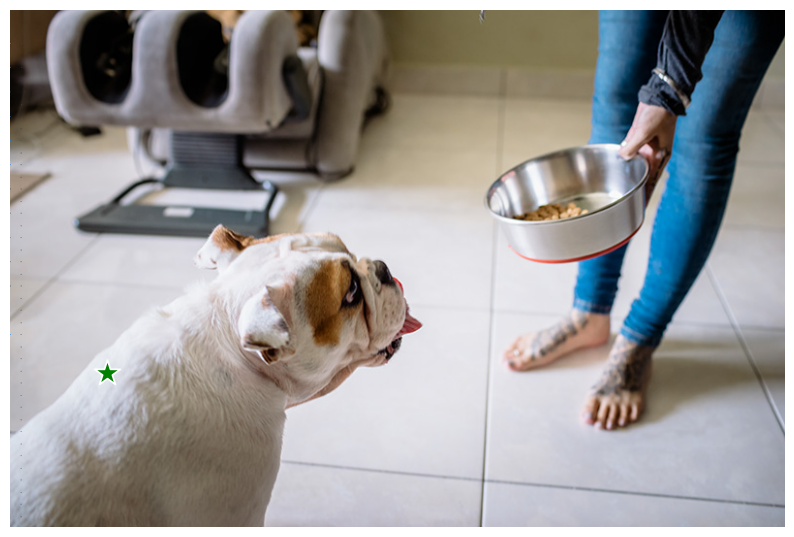

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 